# Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

## Single versus multi label classification

In [3]:
def plot_imgs(img_list, title_list, title):
    plt.figure(1)
    plt.suptitle(title, size=16)
    for i in range(len(img_list)):
        plt.subplot(1,2,i+1)
        plt.imshow(img_list[i])
        plt.title(title_list[i])

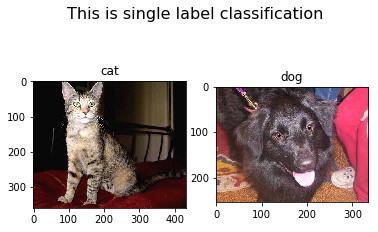

In [5]:
path = "/data/yinterian/dogscats/"
files = !ls {path}valid/cats | head
img_cat = plt.imread(f'{path}valid/cats/{files[0]}')
files = !ls {path}valid/dogs | head
img_dog = plt.imread(f'{path}valid/dogs/{files[0]}')
plot_imgs([img_cat, img_dog], ["cat", "dog"], "This is single label classification")

In <b>single label classification</b> each sample has a single target value. In this example is either "cat" or "dog."

In [6]:
# two examples from planet competition
path = "/data/jhoward/fast/planet/"
train_csv_list = list(open(f'{path}train_v2.csv'))
train_0, label_0 = train_csv_list[1].strip().split(",")
train_1, label_1 = train_csv_list[2].strip().split(",")

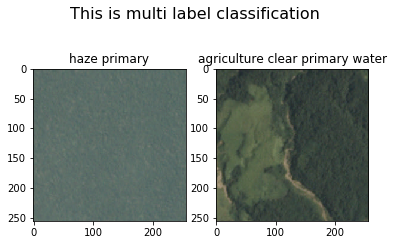

In [7]:
img_0 = plt.imread(f'{path}train-jpg/{train_0}.jpg')
img_1 = plt.imread(f'{path}train-jpg/{train_1}.jpg')
plot_imgs([img_0, img_1], [label_0, label_1], "This is multi label classification")

In <b>multi label classification</b> each sample can have a multiple target values. In this example the first image has 2 labels: "haze" and "primary", the second image has 4 labels: "agriculture", "clear", "primary" and "water."

## Introduction to our first task: 'Dogs vs Cats'

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

Here is the dataset http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. "wget http://files.fast.ai/data/dogscats.zip"

In [8]:
PATH = "data/dogscats/"
#PATH = "/data/yinterian/dogscats/"

### First look at cat pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [9]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [10]:
!ls {PATH}valid

cats  dogs


In [11]:
files = !ls {PATH}valid/cats | head
files

['cat.10000.jpg',
 'cat.10056.jpg',
 'cat.10057.jpg',
 'cat.10061.jpg',
 'cat.10080.jpg',
 'cat.10098.jpg',
 'cat.10104.jpg',
 'cat.10113.jpg',
 'cat.10131.jpg',
 'cat.10135.jpg']

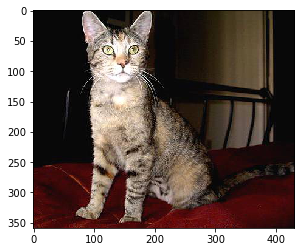

In [12]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [13]:
img.shape

(359, 431, 3)

In [14]:
img[:4,:4]

array([[[8, 8, 8],
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]],

       [[8, 8, 8],
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]],

       [[8, 8, 8],
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]],

       [[8, 8, 8],
        [8, 8, 8],
        [8, 8, 8],
        [8, 8, 8]]], dtype=uint8)

### Our first model

#### Quick start

Here we import the libraries we need. We'll learn about what each does during the course.

In [25]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds of compute time:

In [26]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, 299))
learn = ConvLearner.pretrained(resnet34, data, precompute=True)
learn.fit(0.01, 2)

[ 0.      0.0419  0.0238  0.9922]                              
[ 1.      0.0315  0.0274  0.9893]                              



How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later.

**Key concepts:**
* **Epoch:** During iterative training of a neural network, an Epoch is a single pass through the entire training set.
* **Accuracy:** The ratio of correctly predicted observation to the total observations. 
* **Loss:**  A (computationally feasible) function representing the price paid for inaccuracy of predictions.

#### Understanding the code for our first model

Let's look at this code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing (we are going to use size 299x299 images), image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [27]:
tfms = tfms_from_model(resnet34, 299)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [28]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pretrained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes but we need a model with two classes (cats and dogs). The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs. 


<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [29]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

`precompute=True` triggers a faster way of training this model. Here is how we do it. We use the all layers but the last one (up to layer FC7 in the previous diagram) to precompute activations from the training set. You can think about this as a feature extractor, for every image we get a vector of the size of the input to the last layer (4096 in the diagram). With the precomputed features our training of the last layer is much faster.

**What are model parameters?** A machine learning model is the definition of a mathematical formula with a number of parameters (or weights) that need to be learned from the data. For an example, let's consider logistic regression which is the simplest neural network. Given an input vector $x$ and a set of parameters (weights) $w$ and $b$. A logistic regression has a form:

$$\hat{y}=\sigma(wx +b) $$

Where $\sigma$ is the sigmoid function. 

For the logistic regression $w, b$ are the set of parameters. Given a set of parameters we can make predictions for every input $x$.

**Model training (fitting)**: We can now *fit* the model. This is done through a process known as model training (using gradient descent, which we will be studying later). By training a model with existing data, we are able to fit the model parameters.

**What are model hyparameters?**
A hyperparameter is another kind of parameter whose values are set before to the start of the training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn.

We need to pass two hyperparameters to the `learn.fit` function: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [30]:
learn.fit(1e-2, 2)

[ 0.      0.0424  0.0334  0.9883]                              
[ 1.      0.0374  0.0258  0.9917]                              



#### Choosing a learning rate

The **learning rate** determines how quickly or how slowly you want to update the weight parameters in gradient descent. Too small a learning rate will make a training algorithm converge slowly while too large a learning rate will make the training algorithm
diverge. The learning rate is the most important hyper-parameter to tune for training deep neural networks.

`learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like. Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

  5%|▌         | 19/360 [00:00<00:41,  8.18it/s, loss=0.0223]


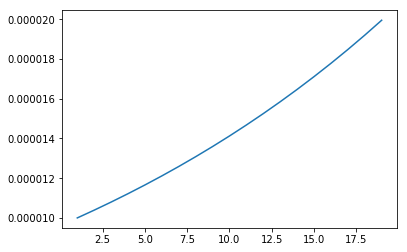

In [31]:
lrf=learn.lr_find()
# should we make this a scaterplot instead? Should we skip this plot for now?
# maybe label the axis
learn.sched.plot_lr()

A **batch** is a set of obseravations from the training set. The bash size (bs) is the size of the batch which is ussually a small constant. Here is the bash size, number and training examples and the ratio between the two. 

In [22]:
print(data.bs, len(data.trn_ds.y), len(data.trn_ds.y)/data.bs )

64 23000 359.375


In the computation of `learn.lr_find()` a batch of training data is used at each iteration. We can see the plot of loss versus learning rate to see where our loss stops decreasing:

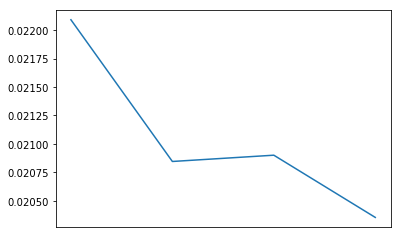

In [32]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use (ignore the first few batches, since there wasn't enough history to have a meaningful average). Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

### Improving our model

#### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizaing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [33]:
from fastai.plots import *

In [34]:
tfms = tfms_from_model(resnet34, 299, aug_tfms=transforms_side_on, max_zoom=1.1)

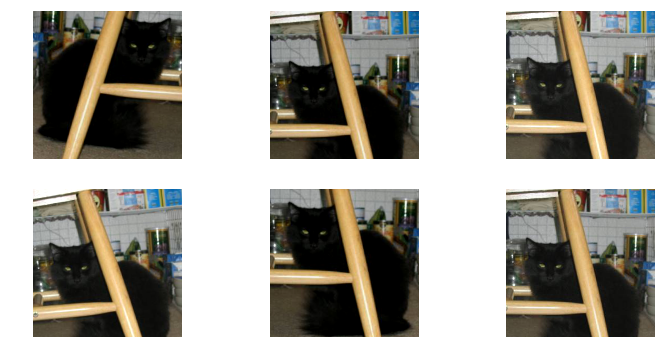

In [35]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [37]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

We fit the final layer from the pre-computed activations as before, but just for one epoch this time to get it started quickly.

In [38]:
learn.fit(1e-2, 1)

[ 0.      0.0442  0.0261  0.9912]                              



To use our augmented data, we can no longer pre-compute the penultimate layer's activations - we never see the exact same picture twice since we have random augmentations, so we don't have the same activations. Therefore we disable `precompute`, the attribute that toggles the use of pre-computed activations.

In [39]:
learn.precompute = False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that even although we're not using the precomputed activations any more, it's still only updating the weights in the last layer when we call `fit`.

In [40]:
learn.fit(1e-2, 3)

[ 0.      0.0416  0.0247  0.9902]                             
[ 1.      0.0398  0.0213  0.9941]                             
[ 2.      0.036   0.0224  0.9917]                             



Our validation loss isn't improving much, so there's probably no point further training the last layer on its own. But there is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
accuracy(*learn.TTA())

I generally see about a 30% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [ ]:
learn.save('299_fc')

#### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [ ]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 2, cycle_len=2)

Why did this complete 4 epochs when we passed an argument of 2? And what is that `cycle_len` parameter? What we've done here is used a technique called *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate, which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

In [ ]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

You should find our TTA accuracy has improved a little more.

In [ ]:
accuracy(*learn.TTA())

## Currently unused

### Class Saliency Visualisation

This method allows an object classifier to be used for object localization, or to better understand misclassifications.

In [ ]:
from IPython.display import display, Math, Latex

Our model visualization is a version of this.
[script](https://github.com/leelabcnbc/cnnvis-pytorch/blob/master/test.ipynb). The details of this approach are descriped in this [paper](https://arxiv.org/pdf/1312.6034.pdf).

Given an image $I_0$, a class $c$, and a classification ConvNet with the class score function $Sc(I)$, we would like to rank the pixels of $I_0$ based on their influence on the score $Sc(I_0)$.

In [ ]:
bs=1
f_model = resnet34
path = "/data/yinterian/dogscats/"
sz=299
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(path, bs, tfms, test_name='test1')
learn = ConvLearner.pretrained(f_model, data)
learn.load('299_no')

In [ ]:
# to get the first element of the validation data
x, y = data.val_dl.dataset[5]
model = learn.model
denorm = tfms[0].denorm
x2 = np.rollaxis(x, 0, 3)
x_org = denorm(x2)

In [ ]:
print(x.shape, x2.shape, x_org.shape)

In [ ]:
plt.imshow(x2)

In [ ]:
plt.imshow(x_org)

In [ ]:
_ = model.eval()

In [ ]:
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor

In [ ]:
x.shape

In [ ]:
xx = T(x).unsqueeze(0)
xx.size()
xx = xx.contiguous()

In [ ]:
input_img = Parameter(xx.cuda(async=True), requires_grad=True)

In [ ]:
if input_img.grad is not None:
    input_img.grad.data.zero_()

In [ ]:
model.zero_grad()

In [ ]:
raw_score = model(input_img)

In [ ]:
raw_score_numpy = raw_score.data.cpu().numpy()
print(np.around(np.exp(raw_score_numpy), decimals=4))

In [ ]:
def show_images(img_original, saliency, title):
    # convert from c01 to 01c
    print(saliency.min(), saliency.max(), saliency.mean(), saliency.std())
    saliency = saliency[::-1]  # to BGR
    saliency = saliency.transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(np.asarray(img_original))
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.suptitle(title)
    plt.show()

In [ ]:
loss = raw_score.sum()

In [ ]:
loss.backward(retain_variables=True)

In [ ]:
show_images(x_org, input_img.grad.data.cpu().numpy()[0], 'naive')


### Visualizing kernels

In [ ]:
# to look at the model
#print(model)

In [ ]:
def plot_first_layer_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        kernel = tensor[i]
        kernel = np.rollaxis(kernel, 0, 3)
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(kernel)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
mm = model.double()

In [ ]:
filters = mm.modules
layer1 = [i for i in mm.children()][0]
tensor = layer1.weight.data.cpu().numpy()

In [ ]:
tensor.shape

In [ ]:
layer1

In [ ]:
# 18 children
[i for i in mm.children()][4][0]

In [ ]:
# here are the 64 7x7x3 top kernels
plot_first_layer_kernels(tensor, num_cols=8)

In [ ]:
layer2 = mm[4][0].conv1
tensor2 = layer2.weight.data.cpu().numpy()

In [ ]:
tensor2.shape 

In [ ]:
def plot_kernels_v2(tensor):
    num_kernels = tensor.shape[0]*tensor.shape[1]
    num_cols = tensor.shape[0]
    num_rows = tensor.shape[1]
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            kernel = tensor[i][j]
            ax1 = fig.add_subplot(num_rows,num_cols,i+1 + j*i)
            ax1.imshow(kernel, cmap='gray')
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
#This is not the right way of visualizing this
plot_kernels_v2(tensor2)

In [ ]:
tensor2[0][0].shape